<a href="https://colab.research.google.com/github/grasht/projects_ML_HW_3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports for Part1
import kagglehub
import pandas as pd
import numpy as np
import os
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Download latest version
path = kagglehub.dataset_download("venkatasubramanian/credit-eda-case-study")

print("Path to dataset files:", path)
os.listdir(path)


Using Colab cache for faster access to the 'credit-eda-case-study' dataset.
Path to dataset files: /kaggle/input/credit-eda-case-study


['Credit EDA Case Study.pdf',
 'application_data.csv',
 'previous_application.csv',
 'columns_description.xlsx']

In [3]:
#Load Data
feat_dict = pd.read_excel(f"{path}/columns_description.xlsx")
df1 = pd.read_csv(f"{path}/application_data.csv")
df2 = pd.read_csv(f"{path}/previous_application.csv")

pk = "SK_ID_CURR"

df1 = df1.drop_duplicates(subset=[pk])
df2 = df2.drop_duplicates(subset=[pk])


In [4]:
print(feat_dict.Row)

0                     SK_ID_CURR
1                         TARGET
2             NAME_CONTRACT_TYPE
3                    CODE_GENDER
4                   FLAG_OWN_CAR
                 ...            
155               DAYS_FIRST_DUE
156    DAYS_LAST_DUE_1ST_VERSION
157                DAYS_LAST_DUE
158             DAYS_TERMINATION
159    NFLAG_INSURED_ON_APPROVAL
Name: Row, Length: 160, dtype: object


In [5]:
df = pd.merge(df1, df2, on="SK_ID_CURR", how="inner")
#df = df.dropna()
print(df.head())
print(df.shape)

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE_x CODE_GENDER FLAG_OWN_CAR  \
0      100002       1           Cash loans           M            N   
1      100003       0           Cash loans           F            N   
2      100004       0      Revolving loans           M            Y   
3      100006       0           Cash loans           F            N   
4      100007       0           Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0               Y             0          202500.0      406597.5   
1               N             0          270000.0     1293502.5   
2               Y             0           67500.0      135000.0   
3               Y             0          135000.0      312682.5   
4               Y             0          121500.0      513000.0   

   AMT_ANNUITY_x  ...  NAME_SELLER_INDUSTRY CNT_PAYMENT NAME_YIELD_GROUP  \
0        24700.5  ...       Auto technology        24.0       low_normal   
1        35698.5  

In [40]:
#The preprocessing pipeline derived during EDA
def pre_pipeline(X):
  #Average EXT_SOURCE
  X["EXT_SOURCE_MEAN"] = X[
      ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
  ].mean(axis=1)

  X.drop(columns=["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"], inplace=True)

  #Drop non predictive ID features
  cols_to_drop_id = ["SK_ID_CURR", "SK_ID_PREV", "DAYS_ID_PUBLISH", ]
  X = X.drop(columns=cols_to_drop_id)

  #Drop MODE and MEDI versions of features. Keep the AVG versions.
  cols_to_drop_not_avg = ['APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
  X = X.drop(columns=cols_to_drop_not_avg)

  #Encoding with pandas dummies
  X = pd.get_dummies(X, drop_first=True)
  X = X.apply(pd.to_numeric, errors='coerce').astype(float)
  X = X.replace([np.inf, -np.inf], np.nan)

  # Impute NaN values with the mean of each column.
  # For columns that are entirely NaN, their mean will be NaN. Fill those with 0.
  X = X.fillna(X.mean(numeric_only=True)).fillna(0)

  # Drop columns with zero variance, as they will produce NaNs in correlation matrix
  std_dev = X.std()
  cols_to_drop_zero_variance = std_dev[std_dev == 0].index
  X = X.drop(columns=cols_to_drop_zero_variance)

  return X

In [34]:
#Map Correlations

feature_names = df.columns.tolist()

print(feature_names)

features = df[feature_names[:-1]]
target = df[feature_names[-1]]
X = features.copy()
X = pre_pipeline(X)

print(X.columns)

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONA

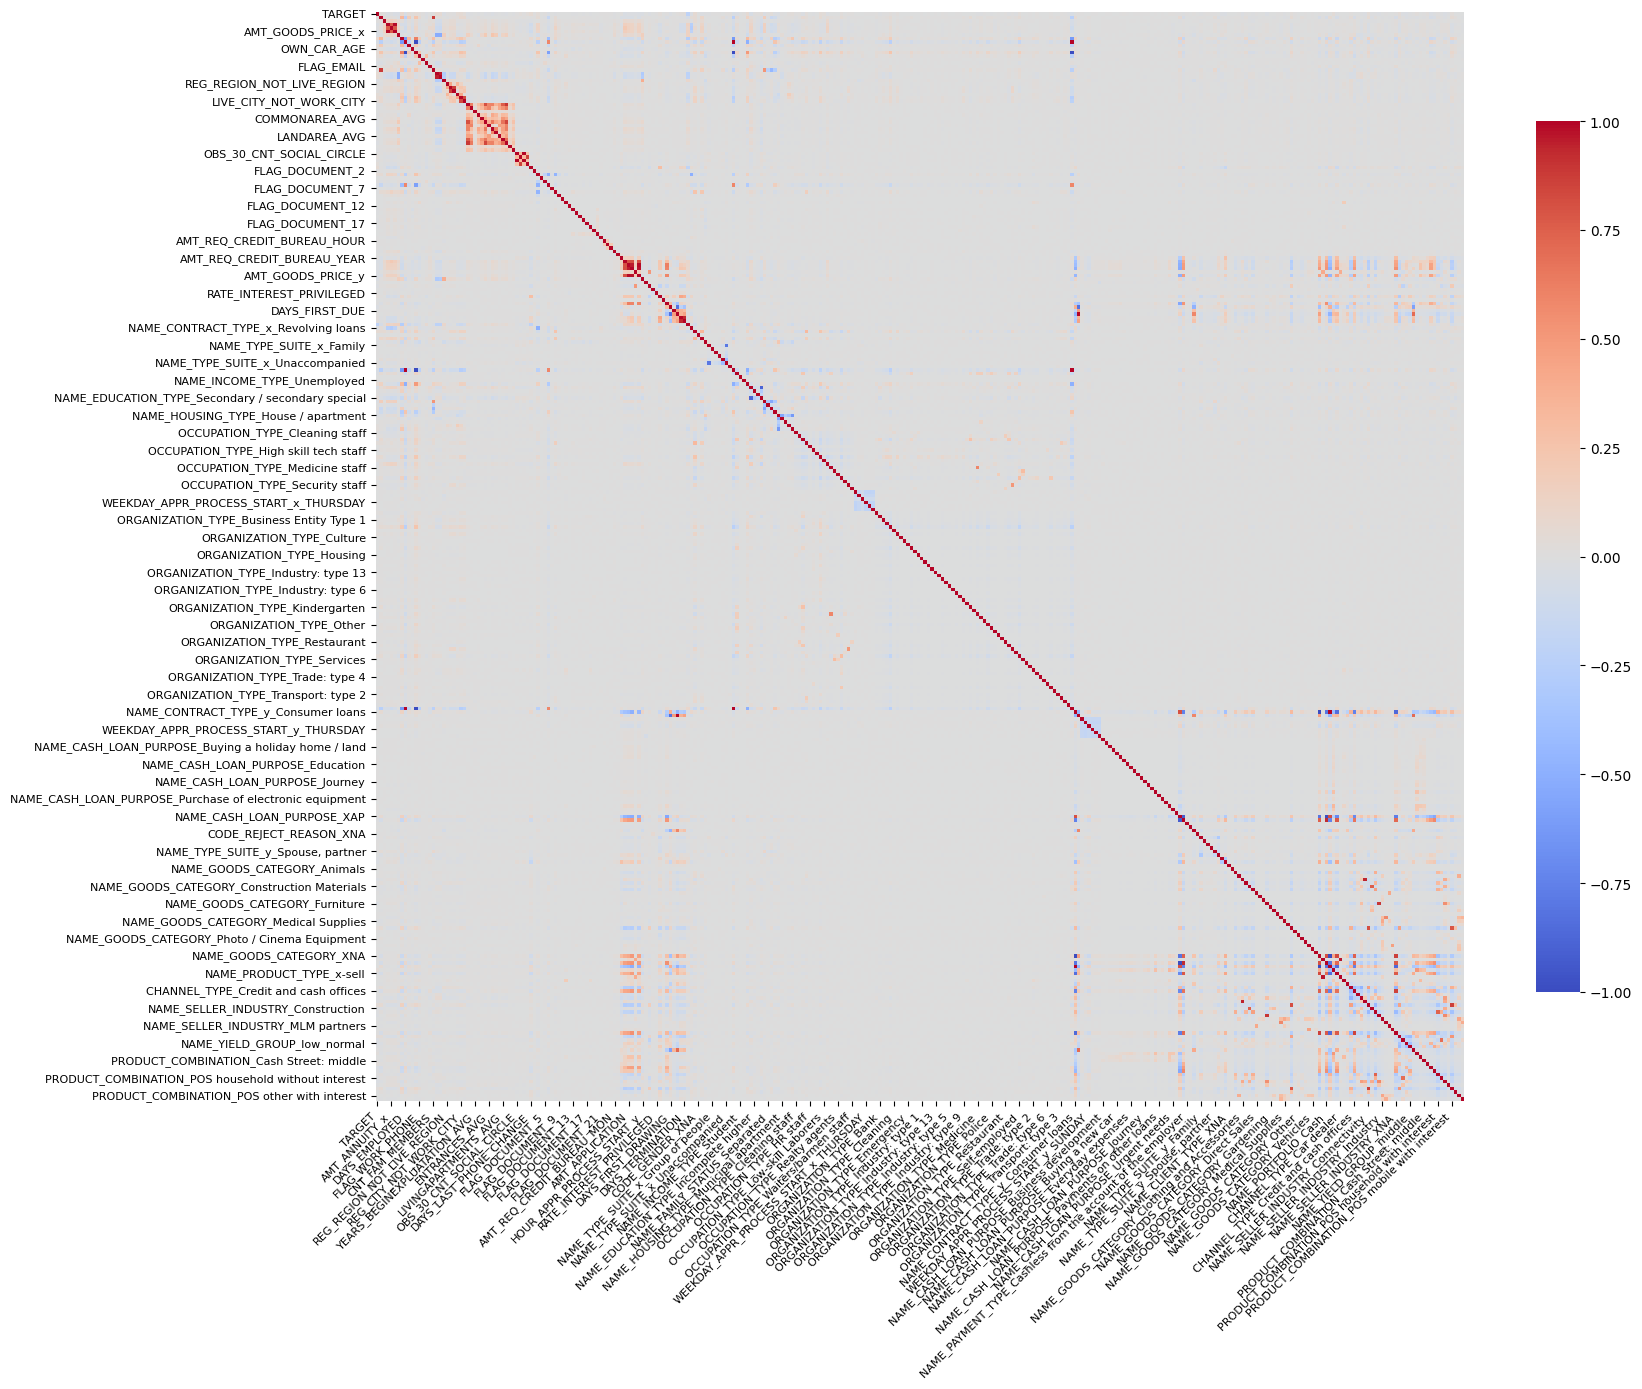

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


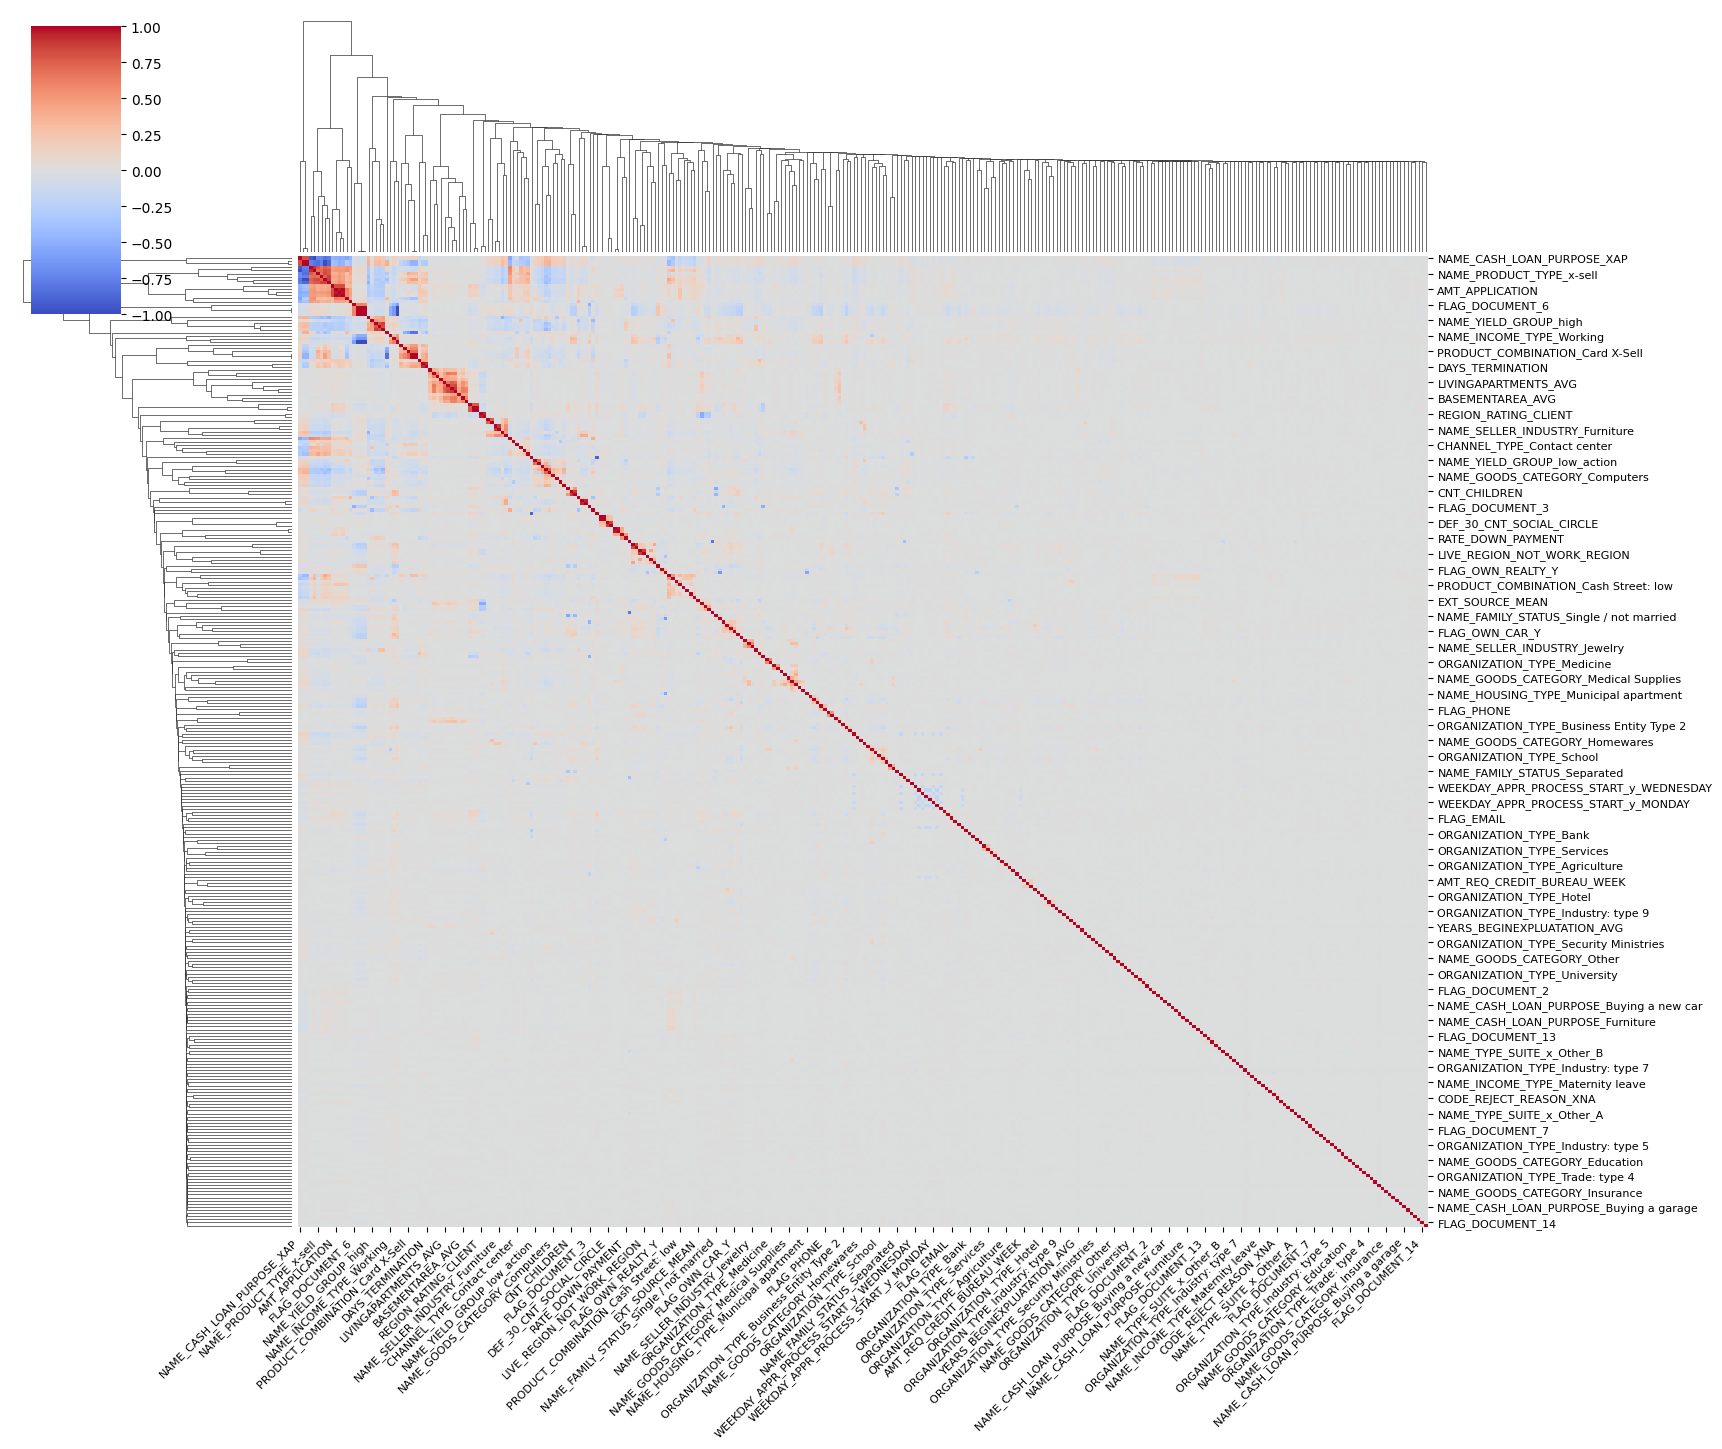

In [35]:
# Calculate correlation matrix
corr_matrix = X.corr()

# Ensure the correlation matrix itself does not contain any non-finite values
corr_matrix = corr_matrix.fillna(0)

#sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
#sns.clustermap(corr_matrix, annot=False, cmap='coolwarm')

plt.figure(figsize=(18, 14))

sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": .8}
)

plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.show()

g = sns.clustermap(
    corr_matrix,
    cmap='coolwarm',
    figsize=(18, 16),
    annot=False
)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=8)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=8)

plt.show()

Correlations with TARGET Feature:
TARGET                                  1.000000
DAYS_BIRTH                              0.079331
DAYS_LAST_PHONE_CHANGE                  0.059605
REGION_RATING_CLIENT_W_CITY             0.057175
CODE_GENDER_M                           0.055816
                                          ...   
DAYS_EMPLOYED                          -0.042698
ORGANIZATION_TYPE_XNA                  -0.043750
NAME_INCOME_TYPE_Pensioner             -0.044015
NAME_EDUCATION_TYPE_Higher education   -0.051592
EXT_SOURCE_MEAN                        -0.211505
Name: TARGET, Length: 312, dtype: float64


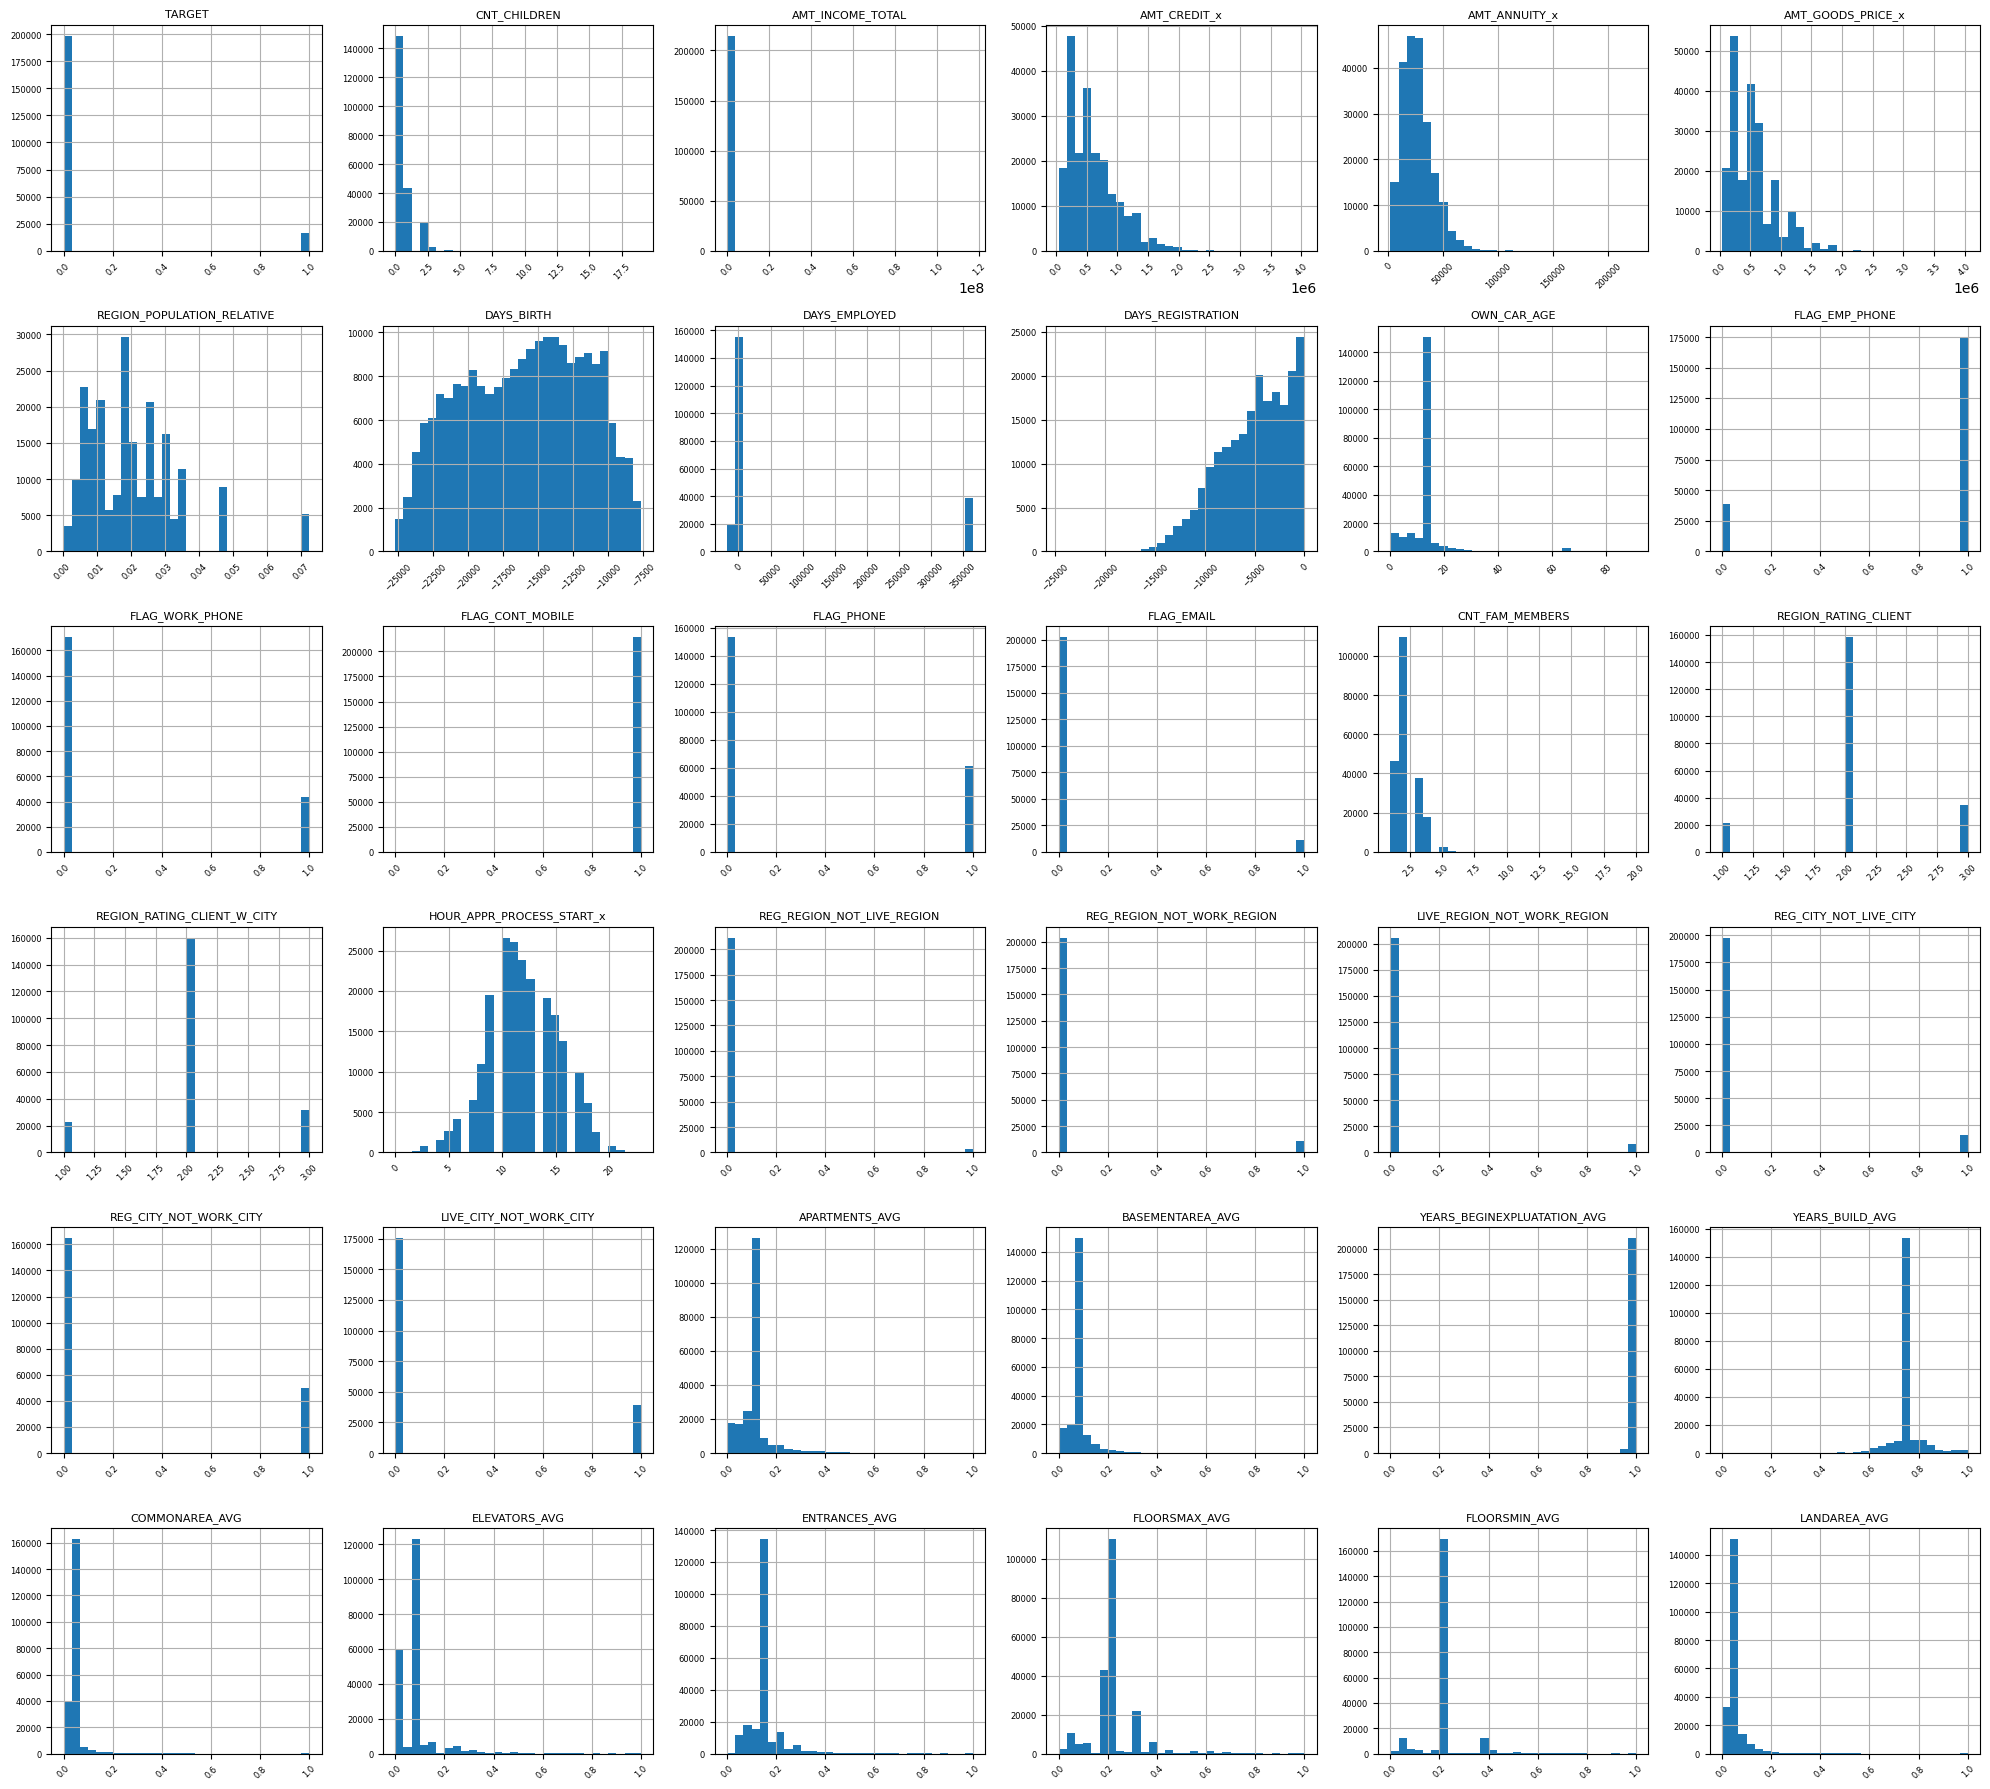

Empty DataFrame
Columns: [Unique Values, Percent of Rows]
Index: []


In [31]:
target_corr = corr_matrix["TARGET"].sort_values(ascending=False)
print("Correlations with TARGET Feature:")
print(target_corr)

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

#Histrogram Distribution checking for skewness
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20,18))  # adjust rows/cols to fit num_cols
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    X[col].hist(bins=30, ax=ax)
    ax.set_title(col, fontsize=8)
    ax.tick_params(axis='x', labelrotation=45, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

# Hide empty subplots if num_cols < nrows*ncols
for ax in axes[len(num_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [43]:
#NerualNetwork_Custom (name so because running this after running the pytorch code below causes issues)
class NeuralNetwork_Custom:
  def __init__(self, input_size, hidden_layers, output_size, kernel="relu", final_actv="sigmoid", seed=1):
    """
    Initialize the neural network parameters.

    Parameters:
    - input_size: int, number of input features
    - hidden_layers: list of int, number of neurons in each hidden layer
    - output_size: int, number of output neurons
    - kernel: str, activation function for hidden layers
    - final_actv: str, final output activation function
    - seed: int, random seed for reproducibility
    """
    self.input_size = input_size
    self.hidden_layers = hidden_layers
    self.output_size = output_size
    self.kernel = kernel.lower()
    self.weights = []
    self.biases = []
    self.dweights = []
    self.dbiases = []
    self.Z = []
    self.A = []
    self.predictions = []
    self.seed = seed
    self.activation_map = {
        "relu": self._relu,
        "sigmoid": self._sigmoid
    }
    self.d_map = {
        "relu": self._d_relu,
        "sigmoid": self._d_sigmoid
    }
    self._set_activation_functions(kernel, final_actv)

  @staticmethod
  def _sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

  @staticmethod
  def _relu(x):
    return np.maximum(0, x)

  @staticmethod
  def _d_sigmoid(x):
    s = np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )
    return s * (1 - s)

  @staticmethod
  def _d_loss(y_hat, y):
    return 2 * (y_hat - y)

  @staticmethod
  def _d_relu(Z):
    return np.where(Z > 0, 1, 0)

  def _set_activation_functions(self, kernel, final_actv):
    self.activation_function = self.activation_map.get(kernel.lower())
    self.final_activation_function = self.activation_map.get(final_actv.lower())
    self.d_activation_function = self.d_map.get(kernel.lower())
    self.d_final_activation_function = self.d_map.get(final_actv.lower())
    if self.activation_function is None:
      raise ValueError("Unsupported activation function")
    if self.final_activation_function is None:
      raise ValueError("Unsupported final activation function")

  def _initialize_params(self):
    self.weights = []
    self.biases = []
    np.random.seed(self.seed)

    layer_sizes = [self.input_size] + self.hidden_layers + [self.output_size]

    for i in range(len(layer_sizes) -1):
      if self.kernel == "relu":
        scale = np.sqrt(2 / layer_sizes[i])
      else:  # sigmoid
        scale = np.sqrt(1 / layer_sizes[i])

      W = np.random.randn(layer_sizes[i+1], layer_sizes[i]) * scale
      b = np.zeros((layer_sizes[i+1], 1))

      self.weights.append(W)
      self.biases.append(b)

  def forward_propagation(self, X):
    """
    Perform forward propagation through the network.

    Parameters:
    - X: input data

    Returns:
    - output of the network
    """
    self.Z = []
    self.A = []
    A = X

    for l in range(len(self.weights)):
      Z = self.weights[l] @ A + self.biases[l]
      A = self.activation_function(Z) if l < len(self.weights) - 1 else self.final_activation_function(Z)
      self.Z.append(Z)
      self.A.append(A)

    return A


  def backward_propagation(self, X, y):
    """
    Perform backward propagation to compute gradients.

    Parameters:
    - X: input data
    - y: true labels
    """
    self.dweights = []
    self.dbiases = []
    m = X.shape[1]

    #Final layer - Keeping it for reference
    dA = self._d_loss(self.predictions, y)
    dZ = dA * self.d_final_activation_function(self.Z[-1])
    A_prev = self.A[-2] if len(self.A) > 1 else X

    dW_L = (1/m) * dZ @ A_prev.T
    db_L = (1/m) * np.sum(dZ, axis=1, keepdims=True)

    self.dweights.insert(0, dW_L)
    self.dbiases.insert(0, db_L)

    for l in reversed(range(len(self.weights) - 1)):
        dA = (self.weights[l+1].T @ dZ)
        dZ = dA * self.d_activation_function(self.Z[l])
        A_prev = self.A[l-1] if l > 0 else X

        dW_L = (1/m) * dZ @ A_prev.T
        db_L = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        self.dweights.insert(0, dW_L)
        self.dbiases.insert(0, db_L)

  def update_weights(self, learning_rate):
    for l in range(len(self.weights)):
      self.weights[l] -= learning_rate * self.dweights[l]
      self.biases[l] -= learning_rate * self.dbiases[l]


  def train(self, X, y, epochs=100, learning_rate=.001):
    """
    Train the neural network using the provided data.

    Parameters:
    - X: input data
    - y: true labels
    - epochs: number of training iterations
    - learning_rate: step size for gradient updates
    """
    X = X.T
    y = y.T
    self._initialize_params()
    for epoch in range(epochs):
      self.predictions = self.forward_propagation(X)

      if np.isnan(self.predictions).any():
        print("NaN detected in predictions")
        break

      self.backward_propagation(X, y)
      self.update_weights(learning_rate)

      #Print every 10% of training
      if epoch % (epochs / 10) == 0:
        loss = self.cost(y, self.predictions)
        print(f"Epoch {epoch}, Loss: {loss}")


  def cost(self, y_true, y_pred):
    """
    Compute the cost/loss of the network predictions.

    Parameters:
    - y_true: true labels
    - y_pred: predicted labels

    Returns:
    - loss value
    """
    #~todo consider supporting BCE
    dif = y_true - y_pred
    return np.mean(dif ** 2)

  def predict(self, X):
    """
    Predict outputs for the given input data.

    Parameters:
    - X: input data

    Returns:
    - predictions
    """
    X = X.T
    self.predictions = self.forward_propagation(X)
    return self.predictions.T

In [45]:
feature_names = df.columns.tolist()
df = df.dropna(subset=[feature_names[-1]])

features = df[feature_names[:-1]]
target = df[feature_names[-1]]
X = features.copy()
X = pre_pipeline(X)
y = np.asarray(target.copy())
X = np.asarray(X.copy())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:

nn = NeuralNetwork_Custom(input_size=X_train.shape[1], hidden_layers=[10, 10], output_size=1)
nn.train(X_train, y_train, 1000, .01)

predictions = nn.predict(X_test)
predictions = (predictions > 0.5).astype(int)
predictions = predictions.flatten()

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Epoch 0, Loss: 0.2404795060575607
Epoch 100, Loss: 0.20260988661402907
Epoch 200, Loss: 0.1860884837092184
Epoch 300, Loss: 0.17661634440311902
Epoch 400, Loss: 0.1693803348652724
Epoch 500, Loss: 0.16266159129431737
Epoch 600, Loss: 0.15600153213921242
Epoch 700, Loss: 0.14973950520988852
Epoch 800, Loss: 0.14430703781279722
Epoch 900, Loss: 0.13994668839082916
Accuracy: 0.8412483672326927


# Test Results
[1000 Epochs, .01 LR, Kernel="ReLU", final_actv="sigmoid"]:

Epoch 0, Loss: 0.2404795060575607

Epoch 100, Loss: 0.20260988661402907

Epoch 200, Loss: 0.1860884837092184

Epoch 300, Loss: 0.17661634440311902

Epoch 400, Loss: 0.1693803348652724

Epoch 500, Loss: 0.16266159129431737

Epoch 600, Loss: 0.15600153213921242

Epoch 700, Loss: 0.14973950520988852

Epoch 800, Loss: 0.14430703781279722

Epoch 900, Loss: 0.13994668839082916

Accuracy: 0.8412483672326927

# Part 2 Create a 2-layer Pytorch NN for comparison.

For this part I followed the guide at [docs.pytorch.org](https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) to get me started. I created a notebook for that excercise [Torch_tutorial.ipynb].

In [46]:
#Imports for Part2
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from torch.nn.modules.activation import ReLU, Sigmoid

In [16]:
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available()) # Checks for GPU access
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device.")

class NeuralNetwork(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.flatten = nn.Flatten()
    self.sigmoid_linear = nn.Sequential(
        nn.Linear(input_size, 16),
        nn.Sigmoid(),
        nn.Linear(16, 1)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.sigmoid_linear(x)
    return logits

model = NeuralNetwork(input_size=X.shape[1]).to(device)
print(model)

# MSE with SGD (Less successful)
#loss_fn = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#Binary Cross Entropy With Adam
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device).float().unsqueeze(1)

    #Compute Prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    #Backpropogration
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device).float().unsqueeze(1) #y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()

      #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

      predicted_labels = (torch.sigmoid(pred) >= 0.5).float()
      correct += (predicted_labels == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

2.9.0+cpu
CUDA available: False
Using cpu device.
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sigmoid_linear): Sequential(
    (0): Linear(in_features=359, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 0.740943 [   64/171486]
loss: 0.546536 [ 6464/171486]
loss: 0.392386 [12864/171486]
loss: 0.368413 [19264/171486]
loss: 0.375143 [25664/171486]
loss: 0.339783 [32064/171486]
loss: 0.347171 [38464/171486]
loss: 0.369802 [44864/171486]
loss: 0.335665 [51264/171486]
loss: 0.308333 [57664/171486]
loss: 0.343306 [64064/171486]
loss: 0.377100 [70464/171486]
loss: 0.356423 [76864/171486]
loss: 0.285697 [83264/171486]
loss: 0.340923 [89664/171486]
loss: 0.261408 [96064/171486]
loss: 0.378823 [102464/171486]
loss: 0.289607 [108864/171486]
loss: 0.304716 [115264/171486]
loss: 0.374483 [121664/171486]
loss: 0.487395 [128064/171486]
loss: 0.332799 [134464/171486]
loss: 

# Results
Best: BCE/ADAM/LR=.001
(Epoch 5)

-------------------------------
loss: 0.283478 [   64/171486]

loss: 0.155900 [ 6464/171486]

loss: 0.282059 [12864/171486]

loss: 0.185233 [19264/171486]

loss: 0.318574 [25664/171486]

loss: 0.207254 [32064/171486]

loss: 0.343425 [38464/171486]

loss: 0.182634 [44864/171486]

loss: 0.278893 [51264/171486]

loss: 0.367618 [57664/171486]

loss: 0.178445 [64064/171486]

loss: 0.170915 [70464/171486]

loss: 0.291671 [76864/171486]

loss: 0.279618 [83264/171486]

loss: 0.223439 [89664/171486]

loss: 0.273692 [96064/171486]

loss: 0.158933 [102464/171486]

loss: 0.298770 [108864/171486]

loss: 0.284070 [115264/171486]

loss: 0.261687 [121664/171486]

loss: 0.429655 [128064/171486]

loss: 0.295022 [134464/171486]

loss: 0.221249 [140864/171486]

loss: 0.303711 [147264/171486]

loss: 0.193079 [153664/171486]

loss: 0.278597 [160064/171486]

loss: 0.200088 [166464/171486]

Test Error:
 Accuracy: 89.2%, Avg loss: 0.258953


#Comparison And Task 3

The pytorch Neural Network appares to run faster and achieving better results only after 5 epochs. The accuracy was also better at 89.2% versus the 84.1% accuracy of my implementation, however this was due to the improvement of switching from MSE (Mean Square Error) to BCE (Binary Cross Entropy). The pytorch model was nearly identical at 85.0% using MSE, suggesting that MSE is not optimal. This makes sense because we are doing binary classification which is known to benefit from BCE. Further, one might consider reducing the number of epochs for the custom Neural Networking and implement an early stopping strategy. This may reduce overfitting in the custom model.

While my network was able to train in a reasonable amount of time, it might also benefit from an optimization strategy such as SGD or Adam. With the trivialness of testing different optimization strategies and loss functions I was able to test multiple and pick the best using Pytorch. I left the MSE logic in the code in comments (#).

I also tested multiple learning rates (.01, .001, and .0001) and found .001 to be the best in terms of accuracy.

In [47]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=20000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8878288859861915


# Part 3 Logistic Regression

For further comparison, a logistic regression model was implemented. Suprisingly the data was quite seperable and it ultimately resulted in an 88.8% accuracy. Not far off from the best Neural Network implementation that I found which was 89.2%. This suggests a strong linear relationship in the data diminishing the need for a model that can learn non-linear relationships. I would like to repeat this experiment with data that in not so linearly seperable to emphasize the difference.